In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "Trihelix"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn001941,MNEMRNLVAALHTKYEQITEKKRSNLTVAGHHHHISANVDAGDRFP...,266,1
1,Achn009891,MFDGVPAEQFHQFIASSRTSVHPLPLSFPLHGSTMQTFPSFDPFPS...,536,1
2,Achn014211,MEVFAADRQISNDVADFPVHLTPFPDAVNMLYDDLTAEIRPPEIEH...,391,1
3,Achn017371,MAPETNDVHELDAHPTNEVNGKQATIEGTNDKSKSQRHPRWTRQET...,429,1
4,Achn020701,MYLSDKPRPIDFYKGGGGERDMVVEVSSVGDLPPHHLQILGDSSGE...,376,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
5370,0.028721,0.0,0.000000,0.010444,0.002611,0.002611,0.000000,0.002611,0.007833,0.007833,...,0.0,0.0,0.000000,0.002611,0.002611,0.000000,0.002611,0.0,0.0,0.000000
1307,0.002047,0.0,0.003071,0.002047,0.001024,0.002047,0.000000,0.001024,0.002047,0.004094,...,0.0,0.0,0.002047,0.001024,0.003071,0.000000,0.002047,0.0,0.0,0.002047
9762,0.000000,0.0,0.004016,0.000000,0.004016,0.004016,0.004016,0.000000,0.000000,0.004016,...,0.0,0.0,0.000000,0.000000,0.004016,0.000000,0.000000,0.0,0.0,0.000000
12140,0.000000,0.0,0.006757,0.000000,0.006757,0.006757,0.000000,0.000000,0.000000,0.006757,...,0.0,0.0,0.000000,0.000000,0.006757,0.000000,0.000000,0.0,0.0,0.000000
11514,0.000000,0.0,0.000000,0.003774,0.003774,0.003774,0.000000,0.000000,0.003774,0.015094,...,0.0,0.0,0.000000,0.000000,0.003774,0.003774,0.000000,0.0,0.0,0.000000


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9989, 441)
X_test: (2498, 441)
y_train: (9989,)
y_test: (2498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:18 635ms/step - accuracy: 0.3750 - loss: 0.6939

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5454 - loss: 0.6898    

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6244 - loss: 0.6708

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.6291

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7087 - loss: 0.5873

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7292 - loss: 0.5578 - val_accuracy: 0.9464 - val_loss: 0.1474


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9219 - loss: 0.1774

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9632 - loss: 0.1190 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9574 - loss: 0.1267

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9555 - loss: 0.1297

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9552 - loss: 0.1300

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9551 - loss: 0.1298 - val_accuracy: 0.9640 - val_loss: 0.1027


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0661

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9716 - loss: 0.0871 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9682 - loss: 0.0947

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9677 - loss: 0.0950

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9673 - loss: 0.0959

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9670 - loss: 0.0970 - val_accuracy: 0.9705 - val_loss: 0.0896


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0406

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9768 - loss: 0.0724 

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9757 - loss: 0.0749

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9741 - loss: 0.0789

102/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9728 - loss: 0.0822

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9722 - loss: 0.0838 - val_accuracy: 0.9595 - val_loss: 0.1146


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9219 - loss: 0.1970

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9717 - loss: 0.0716 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9743 - loss: 0.0696

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9754 - loss: 0.0697

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9761 - loss: 0.0697

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9765 - loss: 0.0697 - val_accuracy: 0.9755 - val_loss: 0.0766


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0213

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9799 - loss: 0.0708 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0663

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9815 - loss: 0.0628

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9822 - loss: 0.0606

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9824 - loss: 0.0597 - val_accuracy: 0.9580 - val_loss: 0.1270


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9375 - loss: 0.1239

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9774 - loss: 0.0690 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9807 - loss: 0.0614

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0587

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9827 - loss: 0.0561

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9831 - loss: 0.0549 - val_accuracy: 0.9780 - val_loss: 0.0676


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0058

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9940 - loss: 0.0206 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0243

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9918 - loss: 0.0285

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9909 - loss: 0.0313

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9903 - loss: 0.0331 - val_accuracy: 0.9730 - val_loss: 0.0836


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9531 - loss: 0.0799

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9861 - loss: 0.0339 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9865 - loss: 0.0346

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9862 - loss: 0.0354

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9857 - loss: 0.0372

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9856 - loss: 0.0378 - val_accuracy: 0.9765 - val_loss: 0.0842


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0246

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9864 - loss: 0.0478 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9874 - loss: 0.0428

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9884 - loss: 0.0393

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0383

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0377 - val_accuracy: 0.9790 - val_loss: 0.0564


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0366

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0290 

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9926 - loss: 0.0274

 76/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0266

101/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0261

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0259 - val_accuracy: 0.9800 - val_loss: 0.0604


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0016

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9911 - loss: 0.0277 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9917 - loss: 0.0262

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9924 - loss: 0.0241

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0236

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9925 - loss: 0.0235 - val_accuracy: 0.9815 - val_loss: 0.0619


Epoch 13/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9844 - loss: 0.0362

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0198 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9946 - loss: 0.0170

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9945 - loss: 0.0175

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0199

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9923 - loss: 0.0226 - val_accuracy: 0.9795 - val_loss: 0.0633


Epoch 14/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9844 - loss: 0.0271

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9968 - loss: 0.0161 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0137

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0128

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0127

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0131 - val_accuracy: 0.9815 - val_loss: 0.0645


Epoch 15/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0050

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0098 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0096

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0095

102/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0091

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9780 - val_loss: 0.0905


Epoch 16/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0118

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0120 

 54/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0118

 80/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0130

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9958 - loss: 0.0145

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0155 - val_accuracy: 0.9725 - val_loss: 0.1071


Epoch 17/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0145

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9936 - loss: 0.0235 

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9938 - loss: 0.0218

 76/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9944 - loss: 0.0195

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9947 - loss: 0.0183

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9948 - loss: 0.0176 - val_accuracy: 0.9835 - val_loss: 0.0625


Epoch 18/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0015

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0034 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9988 - loss: 0.0042

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9986 - loss: 0.0046

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9979 - loss: 0.0057

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0066 - val_accuracy: 0.9825 - val_loss: 0.0628


Epoch 19/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 9.7746e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0057     

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0069

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0085

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0092

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9965 - loss: 0.0094 - val_accuracy: 0.9755 - val_loss: 0.0982


Epoch 20/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0041

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0059 

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0060

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0060

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0066

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0069 - val_accuracy: 0.9840 - val_loss: 0.0738


Epoch 21/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 4.6192e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0039     

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9985 - loss: 0.0050

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0057

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9971 - loss: 0.0099

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0126 - val_accuracy: 0.9765 - val_loss: 0.0863


Epoch 22/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 0.0133

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0051 

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0046

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0044

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0045

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0046 - val_accuracy: 0.9840 - val_loss: 0.0621


Epoch 23/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 1.0000 - loss: 7.6168e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9981 - loss: 0.0065     

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0076

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0075

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0072

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9978 - loss: 0.0069 - val_accuracy: 0.9810 - val_loss: 0.0831


Epoch 24/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 7.8223e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0011     

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0019

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0025

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0031

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0035 - val_accuracy: 0.9765 - val_loss: 0.1147


Epoch 25/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0340

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0060 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - loss: 0.0042

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9990 - loss: 0.0034

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0032

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0036 - val_accuracy: 0.9785 - val_loss: 0.0871


Epoch 26/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9844 - loss: 0.0617

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0154 

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0109

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0090

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0082

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9977 - loss: 0.0079 - val_accuracy: 0.9835 - val_loss: 0.0747


Epoch 27/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 2.5450e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0031     

 52/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0036

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0037

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0040

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0040 - val_accuracy: 0.9795 - val_loss: 0.0959


Epoch 28/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 1.6785e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9929 - loss: 0.0181     

 51/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9927 - loss: 0.0207

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9930 - loss: 0.0209

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - loss: 0.0200

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9937 - loss: 0.0193 - val_accuracy: 0.9750 - val_loss: 0.0914


Epoch 29/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0045

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0025 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0038

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0045

103/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0056

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - loss: 0.0068 - val_accuracy: 0.9775 - val_loss: 0.0868


Epoch 30/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 1.0000 - loss: 0.0012

 27/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.0033 

 53/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0030

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - loss: 0.0032

104/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0035

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9780 - val_loss: 0.0911



[Train Accuracy: 99.89% - Test Accuracy: 97.84%]


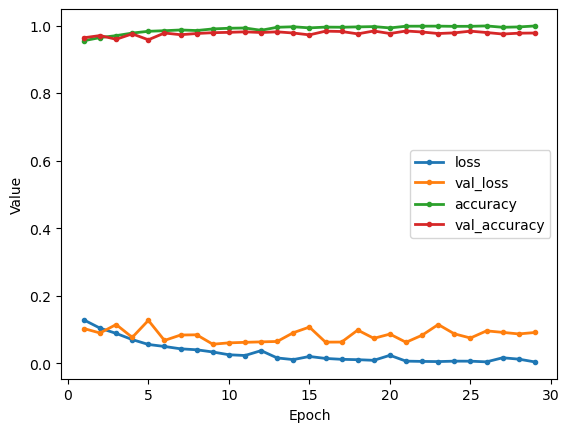

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


 1/79 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
5370,0.015707,0.0,0.000000,0.0,0.002618,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,0.000000,0.0,0.001025,0.0,0.000000,0.001025,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9762,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11514,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (9989, 8965)
X_test: (2498, 8965)
y_train: (9989,)
y_test: (2498,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,295,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,338,561 (8.92 MB)

 Trainable params: 2,338,561 (8.92 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:22 663ms/step - accuracy: 0.5469 - loss: 0.6931

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5111 - loss: 0.6931    

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5186 - loss: 0.6924

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5296 - loss: 0.6909

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5501 - loss: 0.6885

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5736 - loss: 0.6846

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5967 - loss: 0.6784

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6183 - loss: 0.6691

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6379 - loss: 0.6567

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6555 - loss: 0.6420

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6712 - loss: 0.6262

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6855 - loss: 0.6100

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6983 - loss: 0.5939

 92/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7101 - loss: 0.5780

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7207 - loss: 0.5628

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7305 - loss: 0.5482

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7396 - loss: 0.5342

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7480 - loss: 0.5209

125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7547 - loss: 0.5099 - val_accuracy: 0.9890 - val_loss: 0.0326


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0081

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9933 - loss: 0.0162 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9951 - loss: 0.0146

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9956 - loss: 0.0142

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9957 - loss: 0.0146

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9956 - loss: 0.0155

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9955 - loss: 0.0162

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9952 - loss: 0.0170

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9948 - loss: 0.0180

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9945 - loss: 0.0187

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9944 - loss: 0.0192

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9942 - loss: 0.0196

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0198

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9940 - loss: 0.0200

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0201

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0201

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0201

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9939 - loss: 0.0200

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9939 - loss: 0.0199 - val_accuracy: 0.9935 - val_loss: 0.0274


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0015

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0021 

  9/125 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 1.0000 - loss: 0.0021

 15/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.9993 - loss: 0.0038

 22/125 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9990 - loss: 0.0044

 29/125 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9990 - loss: 0.0045

 36/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9988 - loss: 0.0046

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9987 - loss: 0.0046

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9987 - loss: 0.0046

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9987 - loss: 0.0045

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0044

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0043

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0043

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9988 - loss: 0.0043

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0042 

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0042

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9988 - loss: 0.0042

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9989 - loss: 0.0042

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9989 - loss: 0.0041

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9989 - loss: 0.0041 - val_accuracy: 0.9910 - val_loss: 0.0324


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 0.0013

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0013

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 58/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012

 65/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 72/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 79/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 86/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

 93/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

100/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0011

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0011

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0011

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9999 - loss: 0.0011

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9999 - loss: 0.0011 - val_accuracy: 0.9925 - val_loss: 0.0353


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 6.1066e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8318e-04 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1012e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1724e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.4083e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.5436e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6793e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7455e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8222e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9145e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9969e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0508e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0844e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0972e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0993e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0905e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0851e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0849e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 4.0840e-04 - val_accuracy: 0.9935 - val_loss: 0.0342


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 1.7241e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5552e-04 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5613e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5823e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5757e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5773e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6312e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.6887e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7157e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7245e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7306e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7361e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7405e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7415e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7439e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7495e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7507e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7493e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.7479e-04 - val_accuracy: 0.9920 - val_loss: 0.0362


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 7.1785e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2526e-04 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3498e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3781e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3638e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3390e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3145e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2911e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2665e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2451e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2490e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2597e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2757e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2913e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3069e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3192e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3280e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3417e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.3550e-04 - val_accuracy: 0.9935 - val_loss: 0.0388


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 6.6457e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2606e-04 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3041e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3543e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3285e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3112e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2798e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2456e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2128e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1795e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1540e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1272e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1035e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0830e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0696e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0584e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0521e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0464e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 1.0418e-04 - val_accuracy: 0.9915 - val_loss: 0.0425


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 1.0000 - loss: 5.0919e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6382e-05 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2429e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2774e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2375e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1822e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.1313e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0864e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0495e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.0150e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.8867e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.6380e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.4191e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.2227e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 9.0415e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8733e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.7145e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.5616e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 8.4196e-05 - val_accuracy: 0.9920 - val_loss: 0.0424


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 1.8074e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6225e-05 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6114e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8456e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9243e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9816e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0153e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0153e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9784e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9420e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9082e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8742e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8356e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8112e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7875e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7904e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7998e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8151e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8280e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 3.8321e-05 - val_accuracy: 0.9935 - val_loss: 0.0424


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 2.5277e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.2458e-05 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.1348e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.3856e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8972e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1615e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.2856e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.3973e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.6022e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9519e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.2325e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.4538e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.6230e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.7540e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8268e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.8811e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.9440e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.0032e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 5.0425e-05 - val_accuracy: 0.9935 - val_loss: 0.0430


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 1.0000 - loss: 1.1128e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.1388e-05 

 15/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.8253e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7057e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.6334e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5673e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5327e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5092e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4920e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4761e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4567e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4746e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5018e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5242e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5403e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5529e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5636e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.5740e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 2.5815e-05 - val_accuracy: 0.9920 - val_loss: 0.0452



[Train Accuracy: 100.00% - Test Accuracy: 99.44%]


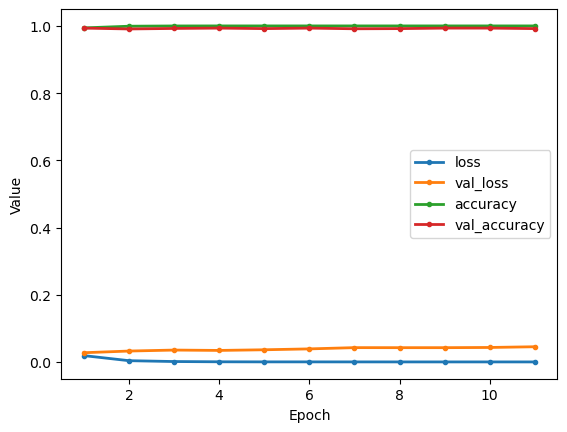

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step

39/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


 1/79 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

37/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

74/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
5370,0.013123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1307,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9762,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12140,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11514,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      40,006,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,047,873 (152.77 MB)

 Trainable params: 40,047,873 (152.77 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 1:47 870ms/step - accuracy: 0.5469 - loss: 0.6931

  2/125 ━━━━━━━━━━━━━━━━━━━━ 15s 128ms/step - accuracy: 0.5547 - loss: 0.6930 

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 140ms/step - accuracy: 0.5625 - loss: 0.6927

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5596 - loss: 0.6927

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 0.5545 - loss: 0.6927

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.5476 - loss: 0.6929

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.5411 - loss: 0.6930

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.5370 - loss: 0.6931

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.5344 - loss: 0.6931

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 0.5317 - loss: 0.6931

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.5301 - loss: 0.6930

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.5292 - loss: 0.6929

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.5282 - loss: 0.6929

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.5270 - loss: 0.6929

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.5263 - loss: 0.6928

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5257 - loss: 0.6927

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5251 - loss: 0.6926

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5243 - loss: 0.6926

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5237 - loss: 0.6925

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5233 - loss: 0.6924

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 0.5228 - loss: 0.6924

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 0.5223 - loss: 0.6923

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5217 - loss: 0.6922

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5213 - loss: 0.6921

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.5207 - loss: 0.6920

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5204 - loss: 0.6919

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5202 - loss: 0.6917

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5200 - loss: 0.6916

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5197 - loss: 0.6915

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 0.5194 - loss: 0.6913

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5192 - loss: 0.6911

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.5190 - loss: 0.6909

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5187 - loss: 0.6908

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.5186 - loss: 0.6905

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5186 - loss: 0.6903

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 0.5187 - loss: 0.6901

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5187 - loss: 0.6898

 38/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 0.5188 - loss: 0.6895

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5190 - loss: 0.6892

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5194 - loss: 0.6889

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5198 - loss: 0.6885

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5204 - loss: 0.6882

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5211 - loss: 0.6878

 44/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5220 - loss: 0.6874

 45/125 ━━━━━━━━━━━━━━━━━━━━ 12s 151ms/step - accuracy: 0.5230 - loss: 0.6869

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.5242 - loss: 0.6864

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 151ms/step - accuracy: 0.5254 - loss: 0.6859

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.5268 - loss: 0.6854

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.5283 - loss: 0.6848

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.5298 - loss: 0.6842

 51/125 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.5314 - loss: 0.6835

 52/125 ━━━━━━━━━━━━━━━━━━━━ 11s 152ms/step - accuracy: 0.5331 - loss: 0.6828

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5348 - loss: 0.6821

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5365 - loss: 0.6813

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5383 - loss: 0.6805

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.5402 - loss: 0.6797

 57/125 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.5421 - loss: 0.6788

 58/125 ━━━━━━━━━━━━━━━━━━━━ 10s 152ms/step - accuracy: 0.5440 - loss: 0.6778

 59/125 ━━━━━━━━━━━━━━━━━━━━ 10s 153ms/step - accuracy: 0.5460 - loss: 0.6769

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5479 - loss: 0.6758 

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5499 - loss: 0.6748

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5519 - loss: 0.6737

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5540 - loss: 0.6725

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5560 - loss: 0.6713

 65/125 ━━━━━━━━━━━━━━━━━━━━ 9s 152ms/step - accuracy: 0.5580 - loss: 0.6701

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5601 - loss: 0.6689

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5621 - loss: 0.6676

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5642 - loss: 0.6662

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5662 - loss: 0.6649

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 152ms/step - accuracy: 0.5683 - loss: 0.6635

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.5703 - loss: 0.6621

 72/125 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5724 - loss: 0.6606

 73/125 ━━━━━━━━━━━━━━━━━━━━ 8s 154ms/step - accuracy: 0.5744 - loss: 0.6591

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5764 - loss: 0.6576

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5785 - loss: 0.6560

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5805 - loss: 0.6544

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5825 - loss: 0.6528

 78/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5844 - loss: 0.6512

 79/125 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 0.5864 - loss: 0.6496

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5884 - loss: 0.6479

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5903 - loss: 0.6462

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5923 - loss: 0.6445

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5942 - loss: 0.6428

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5961 - loss: 0.6410

 85/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5980 - loss: 0.6393

 86/125 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 0.5999 - loss: 0.6375

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6017 - loss: 0.6358

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6036 - loss: 0.6340

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6054 - loss: 0.6322

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6072 - loss: 0.6304

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6090 - loss: 0.6286

 92/125 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6108 - loss: 0.6267

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6126 - loss: 0.6249

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6143 - loss: 0.6231

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6161 - loss: 0.6213

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6178 - loss: 0.6194

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6195 - loss: 0.6176

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6212 - loss: 0.6157

 99/125 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.6229 - loss: 0.6139

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6246 - loss: 0.6121

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6262 - loss: 0.6102

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6279 - loss: 0.6084

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6295 - loss: 0.6065

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6311 - loss: 0.6047

105/125 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.6327 - loss: 0.6028

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6343 - loss: 0.6010

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6359 - loss: 0.5992

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6375 - loss: 0.5973

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6390 - loss: 0.5955

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6406 - loss: 0.5937

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step - accuracy: 0.6421 - loss: 0.5919

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6436 - loss: 0.5900

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6451 - loss: 0.5882

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6466 - loss: 0.5864

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6480 - loss: 0.5846

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 154ms/step - accuracy: 0.6495 - loss: 0.5828

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6510 - loss: 0.5810

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6524 - loss: 0.5792

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6538 - loss: 0.5774

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6552 - loss: 0.5757

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6566 - loss: 0.5739

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6580 - loss: 0.5721

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6594 - loss: 0.5704

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6608 - loss: 0.5686

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.6621 - loss: 0.5669

125/125 ━━━━━━━━━━━━━━━━━━━━ 24s 189ms/step - accuracy: 0.6634 - loss: 0.5651 - val_accuracy: 0.9940 - val_loss: 0.0249


Epoch 2/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 38s 312ms/step - accuracy: 1.0000 - loss: 0.0071

  2/125 ━━━━━━━━━━━━━━━━━━━━ 20s 167ms/step - accuracy: 1.0000 - loss: 0.0067

  3/125 ━━━━━━━━━━━━━━━━━━━━ 19s 157ms/step - accuracy: 1.0000 - loss: 0.0068

  4/125 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 0.0069

  5/125 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 0.0074

  6/125 ━━━━━━━━━━━━━━━━━━━━ 18s 157ms/step - accuracy: 1.0000 - loss: 0.0076

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9997 - loss: 0.0081

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.9995 - loss: 0.0085

  9/125 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.9993 - loss: 0.0087

 10/125 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.9993 - loss: 0.0089

 11/125 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.9992 - loss: 0.0089

 12/125 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 0.9991 - loss: 0.0090

 13/125 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.9991 - loss: 0.0090

 14/125 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - accuracy: 0.9991 - loss: 0.0090

 15/125 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9991 - loss: 0.0089

 16/125 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9991 - loss: 0.0089

 17/125 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9991 - loss: 0.0088

 18/125 ━━━━━━━━━━━━━━━━━━━━ 17s 160ms/step - accuracy: 0.9991 - loss: 0.0088

 19/125 ━━━━━━━━━━━━━━━━━━━━ 16s 160ms/step - accuracy: 0.9991 - loss: 0.0087

 20/125 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9991 - loss: 0.0087

 21/125 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9991 - loss: 0.0086

 22/125 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.9991 - loss: 0.0086

 23/125 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9991 - loss: 0.0086

 24/125 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9991 - loss: 0.0087

 25/125 ━━━━━━━━━━━━━━━━━━━━ 16s 162ms/step - accuracy: 0.9990 - loss: 0.0087

 26/125 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9990 - loss: 0.0087

 27/125 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9990 - loss: 0.0087

 28/125 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9990 - loss: 0.0087

 29/125 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9990 - loss: 0.0087

 30/125 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9989 - loss: 0.0087

 31/125 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9989 - loss: 0.0087

 32/125 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9989 - loss: 0.0087

 33/125 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9988 - loss: 0.0087

 34/125 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9988 - loss: 0.0087

 35/125 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9988 - loss: 0.0088

 36/125 ━━━━━━━━━━━━━━━━━━━━ 14s 163ms/step - accuracy: 0.9988 - loss: 0.0088

 37/125 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9987 - loss: 0.0088

 38/125 ━━━━━━━━━━━━━━━━━━━━ 14s 162ms/step - accuracy: 0.9987 - loss: 0.0088

 39/125 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9987 - loss: 0.0088

 40/125 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9987 - loss: 0.0088

 41/125 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9987 - loss: 0.0088

 42/125 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9987 - loss: 0.0088

 43/125 ━━━━━━━━━━━━━━━━━━━━ 13s 160ms/step - accuracy: 0.9986 - loss: 0.0088

 44/125 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - accuracy: 0.9986 - loss: 0.0088

 45/125 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9986 - loss: 0.0088

 46/125 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9986 - loss: 0.0088

 47/125 ━━━━━━━━━━━━━━━━━━━━ 12s 161ms/step - accuracy: 0.9986 - loss: 0.0088

 48/125 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9986 - loss: 0.0088

 49/125 ━━━━━━━━━━━━━━━━━━━━ 12s 160ms/step - accuracy: 0.9986 - loss: 0.0088

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9986 - loss: 0.0087

 51/125 ━━━━━━━━━━━━━━━━━━━━ 11s 160ms/step - accuracy: 0.9986 - loss: 0.0087

 52/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9985 - loss: 0.0087

 53/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9985 - loss: 0.0087

 54/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9985 - loss: 0.0087

 55/125 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.9985 - loss: 0.0086

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9985 - loss: 0.0086

 57/125 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9985 - loss: 0.0086

 58/125 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9985 - loss: 0.0086

 59/125 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9985 - loss: 0.0086

 60/125 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9985 - loss: 0.0085

 61/125 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - accuracy: 0.9985 - loss: 0.0085

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0085 

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0085

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0084

 65/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0084

 66/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0084

 67/125 ━━━━━━━━━━━━━━━━━━━━ 9s 158ms/step - accuracy: 0.9985 - loss: 0.0084

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9985 - loss: 0.0083

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9985 - loss: 0.0083

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9985 - loss: 0.0083

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9985 - loss: 0.0082

 72/125 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.9985 - loss: 0.0082

 73/125 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 0.9985 - loss: 0.0082

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9985 - loss: 0.0082

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9985 - loss: 0.0081

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9985 - loss: 0.0081

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9985 - loss: 0.0081

 78/125 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9985 - loss: 0.0080

 79/125 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 0.9986 - loss: 0.0080

 80/125 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9986 - loss: 0.0080

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9986 - loss: 0.0080

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 159ms/step - accuracy: 0.9985 - loss: 0.0080

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 85/125 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 86/125 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 87/125 ━━━━━━━━━━━━━━━━━━━━ 6s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9985 - loss: 0.0079

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9985 - loss: 0.0078

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9985 - loss: 0.0078

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9985 - loss: 0.0078

 92/125 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9985 - loss: 0.0078

 93/125 ━━━━━━━━━━━━━━━━━━━━ 5s 160ms/step - accuracy: 0.9985 - loss: 0.0078

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9985 - loss: 0.0078

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9985 - loss: 0.0078

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9985 - loss: 0.0078

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9985 - loss: 0.0077

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.9985 - loss: 0.0077

 99/125 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.9985 - loss: 0.0077

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9985 - loss: 0.0077

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0077

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0077

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0077

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0077

105/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0076

106/125 ━━━━━━━━━━━━━━━━━━━━ 3s 159ms/step - accuracy: 0.9985 - loss: 0.0076

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9985 - loss: 0.0076

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9985 - loss: 0.0076

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9985 - loss: 0.0076

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 159ms/step - accuracy: 0.9985 - loss: 0.0076

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9985 - loss: 0.0076

112/125 ━━━━━━━━━━━━━━━━━━━━ 2s 158ms/step - accuracy: 0.9985 - loss: 0.0075

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step - accuracy: 0.9985 - loss: 0.0075

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0075

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.9985 - loss: 0.0074

125/125 ━━━━━━━━━━━━━━━━━━━━ 21s 170ms/step - accuracy: 0.9985 - loss: 0.0074 - val_accuracy: 0.9950 - val_loss: 0.0175


Epoch 3/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 31s 257ms/step - accuracy: 1.0000 - loss: 0.0026

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 0.0024

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 0.0021

  4/125 ━━━━━━━━━━━━━━━━━━━━ 18s 156ms/step - accuracy: 1.0000 - loss: 0.0020

  5/125 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 0.0019

  6/125 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 0.0018

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 0.0018

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 0.0017

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 0.0017

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 0.0016

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 0.0016

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 0.0015

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 0.0015

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 0.0015

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 0.0014

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 0.0014

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 0.0014

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0013

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0012

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 0.0012

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 0.0012

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0012

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0012

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 0.0012

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 0.0012

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 0.0011

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0011

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0011

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 0.0011

 38/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 0.0011

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 0.0010

 44/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 9.9869e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.9087e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.8335e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.7602e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.6895e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.6219e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 149ms/step - accuracy: 1.0000 - loss: 9.5555e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 11s 150ms/step - accuracy: 1.0000 - loss: 9.4914e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.4286e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.3672e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.3072e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.2483e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.1918e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.1362e-04

 58/125 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 1.0000 - loss: 9.0820e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 9.0293e-04 

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 8.9773e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 8.9273e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 8.8797e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 8.8330e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 8.7872e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.7421e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.6978e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.6570e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.6172e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.5797e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.5427e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 8.5065e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 8.4708e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 8.4363e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.4019e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.3697e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.3380e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 8.3074e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.2771e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.2470e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.2174e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.1882e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.1597e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 8.1317e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 8.1039e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 8.0765e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 8.0493e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 8.0224e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 7.9961e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.9698e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.9440e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.9191e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.8943e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.8698e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.8464e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.8231e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.8001e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.7792e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.7585e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.7377e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.7171e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.6966e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.6761e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.6559e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.6358e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 7.6157e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 7.5958e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.5761e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.5565e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 7.5371e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.5180e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 7.4990e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.4803e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 7.4618e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 7.4437e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.4258e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.4079e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3902e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3726e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3553e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3381e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3209e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3039e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.2872e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.2706e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.2541e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 1.0000 - loss: 7.2378e-04 - val_accuracy: 0.9950 - val_loss: 0.0192


Epoch 4/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 36s 293ms/step - accuracy: 1.0000 - loss: 1.6490e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 2.1577e-04

  3/125 ━━━━━━━━━━━━━━━━━━━━ 19s 156ms/step - accuracy: 1.0000 - loss: 2.3609e-04

  4/125 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 2.4869e-04

  5/125 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 2.5267e-04

  6/125 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 2.5310e-04

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 2.5385e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 2.5410e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 2.5598e-04

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 2.5693e-04

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 2.5686e-04

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 2.5752e-04

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 2.7065e-04

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 2.8102e-04

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 2.8945e-04

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 2.9587e-04

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 3.0122e-04

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 3.0567e-04

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 3.0904e-04

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 3.1181e-04

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 3.1520e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.1780e-04

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 3.1988e-04

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.2153e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 3.2272e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.2355e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.2405e-04

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.2447e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 3.2463e-04

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2450e-04

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 3.2415e-04

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2368e-04

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2319e-04

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2263e-04

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2210e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 3.2148e-04

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.2115e-04

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.2075e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.2039e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.2007e-04

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1973e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 3.1929e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1885e-04

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1847e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1802e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1750e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1696e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1647e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 3.1593e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.1533e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.1474e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 3.1411e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1345e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1277e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1209e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 3.1141e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.1072e-04 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.1005e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0941e-04

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 3.0876e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 3.0810e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 3.0747e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 3.0685e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 149ms/step - accuracy: 1.0000 - loss: 3.0621e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0559e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 3.0494e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 3.0430e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 3.0364e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 3.0300e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 3.0236e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 3.0170e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.0105e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 3.0041e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9996e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9947e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 2.9898e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 2.9847e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9795e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9744e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 2.9692e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9641e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9594e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9546e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 2.9500e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9453e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9405e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9357e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9309e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9261e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9212e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 2.9164e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9115e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9067e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.9018e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.8969e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.8920e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.8871e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 148ms/step - accuracy: 1.0000 - loss: 2.8821e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8771e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8722e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8671e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8621e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8570e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 2.8520e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8471e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8421e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8372e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8322e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8274e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8224e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 2.8175e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.8126e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.8076e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.8028e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7980e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7932e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7883e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 2.7835e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7786e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7738e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7690e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7643e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 2.7599e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.7555e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.7512e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 1.0000 - loss: 2.7469e-04 - val_accuracy: 0.9945 - val_loss: 0.0222


Epoch 5/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 37s 304ms/step - accuracy: 1.0000 - loss: 1.2288e-04

  2/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 1.0000 - loss: 1.1044e-04

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 4.8592e-04

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 6.0197e-04

  5/125 ━━━━━━━━━━━━━━━━━━━━ 19s 159ms/step - accuracy: 1.0000 - loss: 6.3749e-04

  6/125 ━━━━━━━━━━━━━━━━━━━━ 19s 165ms/step - accuracy: 1.0000 - loss: 6.4144e-04

  7/125 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - accuracy: 1.0000 - loss: 6.3246e-04

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 162ms/step - accuracy: 1.0000 - loss: 6.1789e-04

  9/125 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 1.0000 - loss: 6.0143e-04

 10/125 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 1.0000 - loss: 5.8451e-04

 11/125 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 1.0000 - loss: 5.7239e-04

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 1.0000 - loss: 5.5952e-04

 13/125 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 5.4647e-04

 14/125 ━━━━━━━━━━━━━━━━━━━━ 17s 155ms/step - accuracy: 1.0000 - loss: 5.3459e-04

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 5.2282e-04

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 5.1162e-04

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 5.0140e-04

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 154ms/step - accuracy: 1.0000 - loss: 4.9150e-04

 19/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 4.8188e-04

 20/125 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 4.7284e-04

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 152ms/step - accuracy: 1.0000 - loss: 4.6427e-04

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 4.5623e-04

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 4.4931e-04

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 4.4281e-04

 25/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 4.3651e-04

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 4.3047e-04

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.2461e-04

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.1898e-04

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.1353e-04

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.0824e-04

 31/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 4.0314e-04

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 3.9819e-04

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.9343e-04

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.8880e-04

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.8436e-04

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.8010e-04

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 3.7595e-04

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 3.7192e-04

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.6801e-04

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.6423e-04

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.6053e-04

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.5692e-04

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 3.5339e-04

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 3.5014e-04

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.4696e-04

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.4390e-04

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.4090e-04

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.3798e-04

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 3.3513e-04

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.3237e-04

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.2981e-04

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.2730e-04

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.2486e-04

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.2247e-04

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.2013e-04

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 3.1782e-04

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.1557e-04 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.1334e-04

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.1115e-04

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0900e-04

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.0690e-04

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 3.0483e-04

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 3.0281e-04

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 3.0083e-04

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.9888e-04

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.9696e-04

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.9507e-04

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.9320e-04

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.9136e-04

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.8954e-04

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.8776e-04

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.8600e-04

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.8427e-04

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.8256e-04

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.8090e-04

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.7927e-04

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.7766e-04

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.7608e-04

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.7454e-04

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.7302e-04

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.7153e-04

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.7006e-04

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.6861e-04

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.6718e-04

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.6578e-04

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.6439e-04

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.6304e-04

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.6171e-04

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.6040e-04

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 2.5911e-04

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5784e-04

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5659e-04

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5535e-04

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5414e-04

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5294e-04

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5179e-04

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.5066e-04

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4954e-04

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4844e-04

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4735e-04

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4629e-04

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4525e-04

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4424e-04

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4323e-04

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4225e-04

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4127e-04

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4031e-04

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3937e-04

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3844e-04

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3752e-04

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.3661e-04

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3573e-04

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3485e-04

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3400e-04

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3315e-04

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3234e-04

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3154e-04

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.3075e-04

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2997e-04

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2920e-04

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2844e-04

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2768e-04

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2692e-04

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2618e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.2544e-04

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 1.0000 - loss: 2.2471e-04 - val_accuracy: 0.9945 - val_loss: 0.0236


Epoch 6/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 35s 283ms/step - accuracy: 1.0000 - loss: 3.7193e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 3.9869e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 4.5930e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 4.9438e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 5.1919e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.2777e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 5.3230e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 5.3386e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.6152e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 5.8073e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 6.2726e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 6.6421e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 6.9297e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 7.1828e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 7.3667e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 7.5017e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 7.6192e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 7.7182e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 7.8077e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 7.8718e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 7.9200e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 7.9823e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 8.0313e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 8.0733e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 8.1038e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 8.1232e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 8.1342e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 8.1366e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 8.1343e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 8.1285e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 8.1201e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1177e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1286e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1355e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1395e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1415e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 8.1397e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 8.1343e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 8.1292e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 8.1235e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 8.1167e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 8.1093e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 8.1093e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 12s 149ms/step - accuracy: 1.0000 - loss: 8.1061e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.1001e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.0926e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.0830e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.0734e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.0617e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 8.0502e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.0380e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.0244e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 8.0101e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 7.9949e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 7.9807e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 7.9657e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 10s 148ms/step - accuracy: 1.0000 - loss: 7.9494e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.9327e-05 

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.9180e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.9057e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.8926e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.8789e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.8655e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 9s 148ms/step - accuracy: 1.0000 - loss: 7.8513e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.8364e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.8220e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.8071e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.7920e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.7775e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 148ms/step - accuracy: 1.0000 - loss: 7.7629e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.7483e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.7348e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.7230e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.7109e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.7000e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 7.6893e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 7.6781e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6667e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6548e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 7.6425e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 7.6299e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 7.6190e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 7.6084e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 7.5975e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5909e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5839e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5764e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5684e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5600e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5512e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - accuracy: 1.0000 - loss: 7.5420e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.5332e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.5241e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.5149e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.5056e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.4959e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 7.4861e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.4759e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.4655e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.4549e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 7.4440e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 7.4331e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 7.4221e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 7.4111e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.4001e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3893e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3786e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3680e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3658e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3634e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 7.3609e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3583e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3555e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3526e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3495e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3461e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3425e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 7.3387e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3347e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 7.3321e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.3300e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.3278e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.3256e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.3231e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 7.3204e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 7.3178e-05 - val_accuracy: 0.9955 - val_loss: 0.0205


Epoch 7/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 38s 309ms/step - accuracy: 1.0000 - loss: 4.7180e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 4.7185e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 4.6565e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 18s 150ms/step - accuracy: 1.0000 - loss: 4.7445e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 4.6649e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 4.7175e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 4.8997e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 4.9847e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0263e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0348e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0210e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 5.0141e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0045e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 4.9811e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0336e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 5.0655e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0812e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0873e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0903e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0906e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.1470e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.1994e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.2426e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 5.2768e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.3051e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.3281e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.3466e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 5.4132e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.4677e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.5135e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.5549e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.5902e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.6204e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.6462e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6686e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 5.6885e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.7043e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.7164e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.7278e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.7377e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 5.7449e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 5.7496e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.7612e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.7705e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.7931e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.8126e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.8307e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 146ms/step - accuracy: 1.0000 - loss: 5.8467e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 5.8610e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 5.8728e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.8821e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.8892e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.8943e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 5.8981e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 5.9004e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 1.0000 - loss: 5.9010e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 5.9003e-05 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.9002e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.8999e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.8986e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.9001e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.9006e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 5.9001e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8989e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8976e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8954e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8922e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8885e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8841e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 5.8790e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8731e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8666e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8605e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8540e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8483e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8422e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 5.8358e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 5.8288e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 5.8216e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 5.8139e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 5.8060e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 5.7977e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 5.7893e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 5.7813e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7731e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7646e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7558e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7468e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7379e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 5.7286e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.7191e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.7102e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.7012e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.6921e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.6827e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 5.6737e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 5.6645e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.6551e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6459e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 5.6368e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6276e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6187e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6100e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 5.6014e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.5929e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.5842e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.5754e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.5665e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.5587e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 5.5508e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 5.5433e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.5358e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.5282e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.5206e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.5130e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.5054e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 5.4979e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 5.4903e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4830e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4757e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4684e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4611e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4537e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4463e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 5.4391e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 1.0000 - loss: 5.4319e-05 - val_accuracy: 0.9935 - val_loss: 0.0261


Epoch 8/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 35s 284ms/step - accuracy: 1.0000 - loss: 1.6138e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 1.4273e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 152ms/step - accuracy: 1.0000 - loss: 1.5442e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 1.5559e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 18s 151ms/step - accuracy: 1.0000 - loss: 1.5988e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 1.6073e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 154ms/step - accuracy: 1.0000 - loss: 1.6055e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 18s 155ms/step - accuracy: 1.0000 - loss: 1.5961e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 1.6396e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 1.6804e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 1.7232e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 1.7493e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 1.7649e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.7824e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 1.7987e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.8087e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.8139e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 1.8260e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.8371e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.8436e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.8510e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.8578e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.8630e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.8705e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 1.8841e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.8970e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.9092e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.9204e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 149ms/step - accuracy: 1.0000 - loss: 1.9295e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 1.9365e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 1.9463e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 1.9554e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 1.9646e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 1.9729e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.9803e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 1.9880e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 1.9946e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.0012e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 147ms/step - accuracy: 1.0000 - loss: 2.0062e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.0121e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.0173e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.0218e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.0255e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0293e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0329e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0402e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0465e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0518e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0564e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.0606e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.0726e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.0840e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.0949e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1048e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1142e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1240e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1369e-05 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1491e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1606e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1711e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1819e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1930e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.2033e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 147ms/step - accuracy: 1.0000 - loss: 2.2132e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2227e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2316e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2404e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2488e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2565e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.2642e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.2716e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.2786e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.2856e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.2922e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.2982e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3044e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 147ms/step - accuracy: 1.0000 - loss: 2.3102e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 2.3164e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3222e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3277e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3330e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3382e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3431e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3481e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3531e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3581e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3627e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3670e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3713e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3752e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3799e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3843e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3884e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3923e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3958e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3991e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.4022e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4050e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4076e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4100e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4122e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4143e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4163e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 1.0000 - loss: 2.4183e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4202e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4220e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4237e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4257e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4275e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4293e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4311e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.4328e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.4344e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4359e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4374e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4389e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4404e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 2.4417e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4430e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4441e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4451e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4462e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4471e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4485e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 1.0000 - loss: 2.4497e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 2.4509e-05 - val_accuracy: 0.9940 - val_loss: 0.0264


Epoch 9/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 36s 294ms/step - accuracy: 1.0000 - loss: 1.6685e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.4855e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.3871e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.3123e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.2777e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.2589e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.2802e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.6687e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 1.9360e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 148ms/step - accuracy: 1.0000 - loss: 2.1194e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 2.2571e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.3779e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.4628e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.5240e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 2.5787e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.6172e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 2.6448e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 2.6639e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 2.6809e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 2.6960e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 2.7052e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 2.7094e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 2.7101e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 2.7079e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.7045e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.6990e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.6958e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.6909e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.6849e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 148ms/step - accuracy: 1.0000 - loss: 2.6784e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6714e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6632e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.6551e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6460e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6375e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6290e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 1.0000 - loss: 2.6232e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.6168e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.6104e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.6056e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.6000e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.5945e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.5902e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5851e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5819e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5780e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5743e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5700e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5664e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.5622e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5575e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5523e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5467e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5408e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5345e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.5281e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.5217e-05 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.5152e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.5089e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.5025e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.4968e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.4912e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.4854e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4795e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4734e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4672e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4610e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4549e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4489e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.4444e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.4398e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.4351e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.4304e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.4258e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 2.4212e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 145ms/step - accuracy: 1.0000 - loss: 2.4164e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 2.4115e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.4066e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.4017e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3969e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3921e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3872e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.3823e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3773e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3724e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3674e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3627e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3596e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3564e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.3532e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3526e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.3519e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3593e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3662e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3729e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3794e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.3855e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3914e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.3969e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4024e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4077e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4126e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4177e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.4225e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4270e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4313e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4354e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4393e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - accuracy: 1.0000 - loss: 2.4431e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4470e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.4506e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4543e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4577e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4610e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4651e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4691e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4731e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.4769e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 1.0000 - loss: 2.4806e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4845e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4882e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4919e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4955e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.4993e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.5030e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 155ms/step - accuracy: 1.0000 - loss: 2.5066e-05 - val_accuracy: 0.9955 - val_loss: 0.0194


Epoch 10/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 30s 247ms/step - accuracy: 1.0000 - loss: 1.0529e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.2036e-05

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.3908e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 1.5470e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 1.5757e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.5889e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 1.5776e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 1.5760e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 1.5747e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 1.5762e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 1.5744e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 1.5742e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 1.5683e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 1.5685e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 1.5687e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.5665e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.5708e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.5718e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.5725e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 1.5733e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 1.5736e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5717e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5751e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.5764e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.5771e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 1.5778e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 1.5820e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5859e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.5890e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5911e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5925e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5929e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5954e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 1.5970e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.5997e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.6027e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.6055e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.6081e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.6144e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.6205e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 1.6266e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6322e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.6375e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6421e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6458e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6486e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6513e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.6536e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.6553e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.6567e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.6578e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.6584e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.6589e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.6591e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6589e-05 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6583e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6576e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6566e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.6555e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6558e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.6557e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.6559e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.6560e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.6559e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.6559e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 1.6561e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 1.6563e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 150ms/step - accuracy: 1.0000 - loss: 1.6563e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.6561e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.6557e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 1.6553e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6547e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6539e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6532e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6523e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6516e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 1.6507e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6497e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6492e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6487e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6482e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 1.6479e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6474e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 1.0000 - loss: 1.6468e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.6463e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.6460e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.6459e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.6458e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.6456e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 1.0000 - loss: 1.6455e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - accuracy: 1.0000 - loss: 1.6453e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6451e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6448e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6446e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6443e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6440e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6437e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 1.0000 - loss: 1.6434e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.6432e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.6430e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.6426e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.6423e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - accuracy: 1.0000 - loss: 1.6419e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 149ms/step - accuracy: 1.0000 - loss: 1.6415e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6411e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6406e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6401e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6395e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6388e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6381e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 148ms/step - accuracy: 1.0000 - loss: 1.6374e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6366e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6358e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6350e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6342e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6335e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6329e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - accuracy: 1.0000 - loss: 1.6324e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6318e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6313e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6307e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6300e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6293e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6286e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 1.0000 - loss: 1.6279e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - accuracy: 1.0000 - loss: 1.6272e-05 - val_accuracy: 0.9935 - val_loss: 0.0274


Epoch 11/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 28s 231ms/step - accuracy: 1.0000 - loss: 6.0913e-06

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 139ms/step - accuracy: 1.0000 - loss: 7.1774e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 18s 149ms/step - accuracy: 1.0000 - loss: 1.0079e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.3266e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.6203e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 1.7872e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.8678e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 1.9974e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 2.0803e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.1294e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 2.1551e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 2.1712e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 2.1750e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 2.1712e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 2.1611e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 2.1462e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 153ms/step - accuracy: 1.0000 - loss: 2.1276e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 16s 152ms/step - accuracy: 1.0000 - loss: 2.1093e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 2.0937e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 2.0757e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 2.0568e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 2.0368e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 15s 151ms/step - accuracy: 1.0000 - loss: 2.0281e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.0176e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 15s 150ms/step - accuracy: 1.0000 - loss: 2.0072e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 2.0326e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 2.0556e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 2.0740e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 2.0890e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 14s 151ms/step - accuracy: 1.0000 - loss: 2.1010e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 1.0000 - loss: 2.1101e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.1169e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.1316e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 150ms/step - accuracy: 1.0000 - loss: 2.1435e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.1534e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.1618e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - accuracy: 1.0000 - loss: 2.1685e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1734e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1771e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1801e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1823e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1835e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 12s 148ms/step - accuracy: 1.0000 - loss: 2.1837e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1831e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 148ms/step - accuracy: 1.0000 - loss: 2.1821e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1807e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1786e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1764e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1737e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 11s 147ms/step - accuracy: 1.0000 - loss: 2.1708e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1685e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1660e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1633e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1604e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1589e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 1.0000 - loss: 2.1574e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1558e-05 

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.1537e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 147ms/step - accuracy: 1.0000 - loss: 2.1514e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.1487e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.1460e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.1454e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step - accuracy: 1.0000 - loss: 2.1449e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1439e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1428e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1413e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1402e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1396e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1387e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 1.0000 - loss: 2.1375e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1362e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1346e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1327e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1318e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1308e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1295e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 7s 146ms/step - accuracy: 1.0000 - loss: 2.1281e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1265e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1247e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1228e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1209e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1188e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 2.1167e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1143e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1118e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1091e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1063e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1033e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.1004e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - accuracy: 1.0000 - loss: 2.0974e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 146ms/step - accuracy: 1.0000 - loss: 2.0943e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0910e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0878e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0845e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0811e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0776e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 147ms/step - accuracy: 1.0000 - loss: 2.0741e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0706e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0681e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0655e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0629e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0603e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0576e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - accuracy: 1.0000 - loss: 2.0549e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0521e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0493e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0465e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0436e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0408e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0381e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 147ms/step - accuracy: 1.0000 - loss: 2.0362e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.0344e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 147ms/step - accuracy: 1.0000 - loss: 2.0325e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0306e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0287e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0285e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0282e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - accuracy: 1.0000 - loss: 2.0278e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0274e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0269e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0264e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0259e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0252e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0245e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 1.0000 - loss: 2.0238e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 154ms/step - accuracy: 1.0000 - loss: 2.0230e-05 - val_accuracy: 0.9940 - val_loss: 0.0273


Epoch 12/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 36s 291ms/step - accuracy: 1.0000 - loss: 3.0247e-06

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 6.7373e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 144ms/step - accuracy: 1.0000 - loss: 7.8808e-06

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 145ms/step - accuracy: 1.0000 - loss: 8.0204e-06

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 147ms/step - accuracy: 1.0000 - loss: 7.9604e-06

  6/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 7.8172e-06

  7/125 ━━━━━━━━━━━━━━━━━━━━ 17s 146ms/step - accuracy: 1.0000 - loss: 7.7832e-06

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 9.6447e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 1.0901e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.1737e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 1.2351e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 1.0000 - loss: 1.2764e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 151ms/step - accuracy: 1.0000 - loss: 1.3086e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.3312e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.3520e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.3659e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 1.3737e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 149ms/step - accuracy: 1.0000 - loss: 1.3818e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 148ms/step - accuracy: 1.0000 - loss: 1.3909e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.3991e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.4046e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 1.4073e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 147ms/step - accuracy: 1.0000 - loss: 1.4101e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.4110e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.4103e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.4088e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.4061e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 1.0000 - loss: 1.4036e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.4007e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 1.3990e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.3968e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.3945e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.3918e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 145ms/step - accuracy: 1.0000 - loss: 1.3891e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3866e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3835e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3810e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3788e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3763e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3734e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.3702e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3670e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3636e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3597e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3565e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3530e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 1.0000 - loss: 1.3494e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.3459e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3425e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3390e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3361e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3336e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3313e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.3288e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3262e-05 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3236e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3209e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3183e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3159e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3134e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.3109e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3082e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3059e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3035e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.3012e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 142ms/step - accuracy: 1.0000 - loss: 1.2989e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.2968e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.2946e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2923e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2900e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2876e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2852e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2833e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2813e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2793e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2773e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.2753e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2735e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2716e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2697e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2678e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2658e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.2638e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2621e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2604e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2585e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2566e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2547e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2530e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.2513e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2502e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2491e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2479e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2467e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2455e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2442e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.2429e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2415e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2401e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2408e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2420e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2430e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2444e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 1.2461e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.2478e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2493e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2510e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2527e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 145ms/step - accuracy: 1.0000 - loss: 1.2543e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.2559e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 1.2573e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2587e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2599e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2611e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2622e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2633e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 1.2644e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 1.0000 - loss: 1.2655e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2665e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2675e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2683e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2691e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2698e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2705e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 1.2711e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 1.0000 - loss: 1.2717e-05 - val_accuracy: 0.9950 - val_loss: 0.0246


Epoch 13/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 49s 400ms/step - accuracy: 1.0000 - loss: 4.6325e-06

  2/125 ━━━━━━━━━━━━━━━━━━━━ 18s 147ms/step - accuracy: 1.0000 - loss: 6.3475e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 1.6112e-05

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 1.9115e-05

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 2.1554e-05

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 2.2901e-05

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 2.3329e-05

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 2.3501e-05

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 2.3402e-05

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 1.0000 - loss: 2.3258e-05

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 2.2976e-05

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.2990e-05

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 2.2961e-05

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.2908e-05

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 1.0000 - loss: 2.2776e-05

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2594e-05

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 2.2426e-05

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 2.2223e-05

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 2.2009e-05

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 2.1775e-05

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.1536e-05

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.1289e-05

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.1054e-05

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.0819e-05

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.0594e-05

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 2.0381e-05

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 2.0175e-05

 28/125 ━━━━━━━━━━━━━━━━━━━━ 14s 145ms/step - accuracy: 1.0000 - loss: 1.9975e-05

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9776e-05

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9593e-05

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9414e-05

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9249e-05

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.9114e-05

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 1.8979e-05

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8919e-05

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 1.0000 - loss: 1.8852e-05

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8778e-05

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8699e-05

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8635e-05

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8580e-05

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 1.8521e-05

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8460e-05

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8396e-05

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8338e-05

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8291e-05

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8242e-05

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8191e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.8140e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.8087e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.8031e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.7973e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.7914e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.7855e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 1.0000 - loss: 1.7794e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7733e-05 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7671e-05

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.7610e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 1.7547e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.7486e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.7429e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.7370e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7311e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7252e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7192e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7137e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7083e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.7029e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.6988e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.6947e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.6905e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.6865e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.6825e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.6784e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.6742e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.6700e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.6659e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6618e-05

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6580e-05

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6543e-05

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6505e-05

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6466e-05

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6427e-05

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 1.6389e-05

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6350e-05

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6311e-05

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6271e-05

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6232e-05

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6192e-05

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6152e-05

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 1.6112e-05

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.6072e-05

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.6032e-05

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.5992e-05

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.5952e-05

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 1.5913e-05

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.5875e-05

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 1.5836e-05

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5799e-05

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5762e-05

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5725e-05

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5688e-05

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5651e-05

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5614e-05

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 1.5577e-05

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5540e-05

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5503e-05

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5467e-05

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5430e-05

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5393e-05

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5356e-05

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 1.5319e-05

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5284e-05

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5248e-05

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5213e-05

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5178e-05

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5142e-05

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 1.5108e-05

118/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5074e-05

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5041e-05

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.5008e-05

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.4974e-05

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.4946e-05

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 1.4917e-05

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.4888e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 1.4860e-05

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 1.4832e-05 - val_accuracy: 0.9940 - val_loss: 0.0279


Epoch 14/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 29s 241ms/step - accuracy: 1.0000 - loss: 1.0739e-05

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 8.6954e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 16s 137ms/step - accuracy: 1.0000 - loss: 8.1625e-06

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 8.6280e-06

  5/125 ━━━━━━━━━━━━━━━━━━━━ 17s 142ms/step - accuracy: 1.0000 - loss: 8.6478e-06

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 8.7087e-06

  7/125 ━━━━━━━━━━━━━━━━━━━━ 18s 153ms/step - accuracy: 1.0000 - loss: 8.6893e-06

  8/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 8.6134e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 1.0000 - loss: 8.6186e-06

 10/125 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 1.0000 - loss: 8.6041e-06

 11/125 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - accuracy: 1.0000 - loss: 8.5673e-06

 12/125 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 1.0000 - loss: 8.5088e-06

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 150ms/step - accuracy: 1.0000 - loss: 8.4781e-06

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 149ms/step - accuracy: 1.0000 - loss: 8.4600e-06

 15/125 ━━━━━━━━━━━━━━━━━━━━ 16s 148ms/step - accuracy: 1.0000 - loss: 8.4297e-06

 16/125 ━━━━━━━━━━━━━━━━━━━━ 16s 147ms/step - accuracy: 1.0000 - loss: 8.3844e-06

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 147ms/step - accuracy: 1.0000 - loss: 8.3285e-06

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 146ms/step - accuracy: 1.0000 - loss: 8.2851e-06

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 145ms/step - accuracy: 1.0000 - loss: 8.2332e-06

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 8.1927e-06

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.1506e-06

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.1112e-06

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.0686e-06

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.0274e-06

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 7.9797e-06

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 7.9354e-06

 27/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.8889e-06

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.8436e-06

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.7968e-06

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.7537e-06

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 7.7095e-06

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 7.6633e-06

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 7.6189e-06

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 1.0000 - loss: 7.5752e-06

 35/125 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 7.5400e-06

 36/125 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 1.0000 - loss: 7.5043e-06

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.4683e-06

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.4331e-06

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.4053e-06

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.3759e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.3472e-06

 42/125 ━━━━━━━━━━━━━━━━━━━━ 12s 146ms/step - accuracy: 1.0000 - loss: 7.3183e-06

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2929e-06

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2666e-06

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2407e-06

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2428e-06

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2427e-06

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 145ms/step - accuracy: 1.0000 - loss: 7.2462e-06

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.2489e-06

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.2504e-06

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.2502e-06

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.2487e-06

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.2477e-06

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 1.0000 - loss: 7.2453e-06

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 1.0000 - loss: 7.2454e-06

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2449e-06 

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2430e-06

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2400e-06

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2363e-06

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2315e-06

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2258e-06

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 7.2202e-06

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.2420e-06

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.2627e-06

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.2818e-06

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.3005e-06

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.3176e-06

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.3332e-06

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 7.3482e-06

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.3618e-06

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.3737e-06

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.3847e-06

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.3942e-06

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.4042e-06

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 7.4147e-06

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 7.4238e-06

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.4317e-06

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.4396e-06

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 7.4464e-06

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 7.4523e-06

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.4586e-06

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.4646e-06

 83/125 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 7.4697e-06

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4754e-06

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4805e-06

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4847e-06

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4890e-06

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4924e-06

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.4967e-06

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 1.0000 - loss: 7.5001e-06

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5036e-06

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5081e-06

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5118e-06

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5158e-06

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5200e-06

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5238e-06

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 1.0000 - loss: 7.5276e-06

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5319e-06

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5361e-06

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5398e-06

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5430e-06

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5461e-06

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5495e-06

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 7.5523e-06

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5548e-06

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5571e-06

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5590e-06

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5631e-06

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5668e-06

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5700e-06

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 7.5733e-06

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5774e-06

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5812e-06

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5849e-06

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5891e-06

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5929e-06

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5963e-06

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 7.5995e-06

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 7.6022e-06

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 7.6045e-06

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.6084e-06

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.6118e-06

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.6148e-06

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.6174e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 7.6197e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 7.6220e-06 - val_accuracy: 0.9940 - val_loss: 0.0287


Epoch 15/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 29s 236ms/step - accuracy: 1.0000 - loss: 5.7046e-06

  2/125 ━━━━━━━━━━━━━━━━━━━━ 16s 136ms/step - accuracy: 1.0000 - loss: 5.0086e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 4.7202e-06

  4/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 4.5255e-06

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 1.0000 - loss: 4.3107e-06

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 4.6383e-06

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 4.8093e-06

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 4.8994e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 1.0000 - loss: 4.9276e-06

 10/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.9587e-06

 11/125 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 1.0000 - loss: 4.9682e-06

 12/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0034e-06

 13/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0129e-06

 14/125 ━━━━━━━━━━━━━━━━━━━━ 16s 144ms/step - accuracy: 1.0000 - loss: 5.0032e-06

 15/125 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 4.9883e-06

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 4.9749e-06

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 143ms/step - accuracy: 1.0000 - loss: 4.9874e-06

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0328e-06

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0735e-06

 20/125 ━━━━━━━━━━━━━━━━━━━━ 15s 144ms/step - accuracy: 1.0000 - loss: 5.0989e-06

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.1172e-06

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.1293e-06

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.1404e-06

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.1716e-06

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.1929e-06

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 5.2196e-06

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 5.2472e-06

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.2776e-06

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.3040e-06

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 5.3272e-06

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.3490e-06

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.3675e-06

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.3806e-06

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 143ms/step - accuracy: 1.0000 - loss: 5.3893e-06

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 5.3955e-06

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 5.4018e-06

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 5.4076e-06

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 5.4103e-06

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 5.4113e-06

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 142ms/step - accuracy: 1.0000 - loss: 5.4102e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4070e-06

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4040e-06

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4022e-06

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.4006e-06

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.3981e-06

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.3957e-06

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.3934e-06

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 5.3894e-06

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3840e-06

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3797e-06

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3750e-06

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3697e-06

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3650e-06

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 5.3638e-06

 55/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3645e-06 

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3655e-06

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3664e-06

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3664e-06

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3657e-06

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 142ms/step - accuracy: 1.0000 - loss: 5.3643e-06

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 5.3621e-06

 62/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3597e-06

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3567e-06

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3530e-06

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3488e-06

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3439e-06

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3404e-06

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3368e-06

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 5.3341e-06

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3309e-06

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3272e-06

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3229e-06

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3183e-06

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3153e-06

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3119e-06

 76/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 5.3108e-06

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.3089e-06

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.3067e-06

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.3048e-06

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.3023e-06

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.2996e-06

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 5.2969e-06

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2936e-06

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2900e-06

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2862e-06

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2826e-06

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2792e-06

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2756e-06

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2719e-06

 90/125 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.2682e-06

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2646e-06

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2615e-06

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2580e-06

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2542e-06

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2504e-06

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2465e-06

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 5.2423e-06

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2380e-06

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2335e-06

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2290e-06

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2248e-06

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2205e-06

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2173e-06

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 5.2140e-06

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2182e-06

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2227e-06

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2268e-06

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2305e-06

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2341e-06

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2376e-06

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 5.2407e-06

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2435e-06

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2488e-06

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2539e-06

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2586e-06

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2631e-06

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2675e-06

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 5.2720e-06

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2763e-06

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2806e-06

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2846e-06

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.2884e-06

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.3384e-06

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 5.3873e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 5.4350e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 1.0000 - loss: 5.4820e-06 - val_accuracy: 0.9955 - val_loss: 0.0246


Epoch 16/100


  1/125 ━━━━━━━━━━━━━━━━━━━━ 27s 220ms/step - accuracy: 1.0000 - loss: 2.2051e-06

  2/125 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 2.5233e-06

  3/125 ━━━━━━━━━━━━━━━━━━━━ 17s 143ms/step - accuracy: 1.0000 - loss: 2.8926e-06

  4/125 ━━━━━━━━━━━━━━━━━━━━ 17s 141ms/step - accuracy: 1.0000 - loss: 3.5922e-06

  5/125 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 1.0000 - loss: 4.1525e-06

  6/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 4.9668e-06

  7/125 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 1.0000 - loss: 5.4372e-06

  8/125 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 1.0000 - loss: 6.2168e-06

  9/125 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 1.0000 - loss: 6.7397e-06

 10/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 7.1655e-06

 11/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 7.4668e-06

 12/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 7.7350e-06

 13/125 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 7.9388e-06

 14/125 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 8.0775e-06

 15/125 ━━━━━━━━━━━━━━━━━━━━ 15s 139ms/step - accuracy: 1.0000 - loss: 8.1698e-06

 16/125 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - accuracy: 1.0000 - loss: 8.2476e-06

 17/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 8.3134e-06

 18/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 8.3514e-06

 19/125 ━━━━━━━━━━━━━━━━━━━━ 15s 142ms/step - accuracy: 1.0000 - loss: 8.3932e-06

 20/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 8.4251e-06

 21/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.4461e-06

 22/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.5596e-06

 23/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 8.6550e-06

 24/125 ━━━━━━━━━━━━━━━━━━━━ 14s 143ms/step - accuracy: 1.0000 - loss: 8.7813e-06

 25/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.8913e-06

 26/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 8.9795e-06

 27/125 ━━━━━━━━━━━━━━━━━━━━ 14s 144ms/step - accuracy: 1.0000 - loss: 9.0954e-06

 28/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.1939e-06

 29/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.2790e-06

 30/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.3497e-06

 31/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.4239e-06

 32/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.4947e-06

 33/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.5549e-06

 34/125 ━━━━━━━━━━━━━━━━━━━━ 13s 144ms/step - accuracy: 1.0000 - loss: 9.6042e-06

 35/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.6536e-06

 36/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.6948e-06

 37/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.7279e-06

 38/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.7708e-06

 39/125 ━━━━━━━━━━━━━━━━━━━━ 12s 144ms/step - accuracy: 1.0000 - loss: 9.8146e-06

 40/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.8544e-06

 41/125 ━━━━━━━━━━━━━━━━━━━━ 12s 143ms/step - accuracy: 1.0000 - loss: 9.8867e-06

 42/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.9127e-06

 43/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.9366e-06

 44/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.9583e-06

 45/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.9793e-06

 46/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 9.9961e-06

 47/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.0010e-05

 48/125 ━━━━━━━━━━━━━━━━━━━━ 11s 143ms/step - accuracy: 1.0000 - loss: 1.0026e-05

 49/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0039e-05

 50/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0051e-05

 51/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0062e-05

 52/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0071e-05

 53/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0078e-05

 54/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0082e-05

 55/125 ━━━━━━━━━━━━━━━━━━━━ 10s 143ms/step - accuracy: 1.0000 - loss: 1.0086e-05

 56/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0088e-05 

 57/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0089e-05

 58/125 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - accuracy: 1.0000 - loss: 1.0092e-05

 59/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.0093e-05

 60/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.0093e-05

 61/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.0090e-05

 62/125 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 1.0000 - loss: 1.0088e-05

 63/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0088e-05

 64/125 ━━━━━━━━━━━━━━━━━━━━ 8s 144ms/step - accuracy: 1.0000 - loss: 1.0086e-05

 65/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0083e-05

 66/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0079e-05

 67/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0074e-05

 68/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0068e-05

 69/125 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 1.0000 - loss: 1.0060e-05

 70/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.0052e-05

 71/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.0043e-05

 72/125 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.0036e-05

 73/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.0029e-05

 74/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.0021e-05

 75/125 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 1.0000 - loss: 1.0012e-05

 76/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 1.0002e-05

 77/125 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 9.9919e-06

 78/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9813e-06

 79/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9696e-06

 80/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9571e-06

 81/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9440e-06

 82/125 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 1.0000 - loss: 9.9313e-06

 83/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.9190e-06

 84/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.9063e-06

 85/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.8931e-06

 86/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.8795e-06

 87/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.8668e-06

 88/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.8536e-06

 89/125 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.8400e-06

 90/125 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 9.8260e-06

 91/125 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 9.8117e-06

 92/125 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 9.7973e-06

 93/125 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 9.7825e-06

 94/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 9.7676e-06

 95/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 9.7530e-06

 96/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 9.7379e-06

 97/125 ━━━━━━━━━━━━━━━━━━━━ 4s 143ms/step - accuracy: 1.0000 - loss: 9.7225e-06

 98/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.7074e-06

 99/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.6921e-06

100/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.6770e-06

101/125 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.6617e-06

102/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 9.6461e-06

103/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 9.6305e-06

104/125 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 1.0000 - loss: 9.6147e-06

105/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.6005e-06

106/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5862e-06

107/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5717e-06

108/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5570e-06

109/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5422e-06

110/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5273e-06

111/125 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.5163e-06

112/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.5052e-06

113/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4942e-06

114/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4831e-06

115/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4717e-06

116/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4600e-06

117/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4480e-06

118/125 ━━━━━━━━━━━━━━━━━━━━ 1s 144ms/step - accuracy: 1.0000 - loss: 9.4360e-06

119/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 9.4239e-06

120/125 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 1.0000 - loss: 9.4118e-06

121/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.3997e-06

122/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.3875e-06

123/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.3751e-06

124/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.3626e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 1.0000 - loss: 9.3505e-06

125/125 ━━━━━━━━━━━━━━━━━━━━ 19s 152ms/step - accuracy: 1.0000 - loss: 9.3385e-06 - val_accuracy: 0.9955 - val_loss: 0.0253



[Train Accuracy: 100.00% - Test Accuracy: 99.60%]


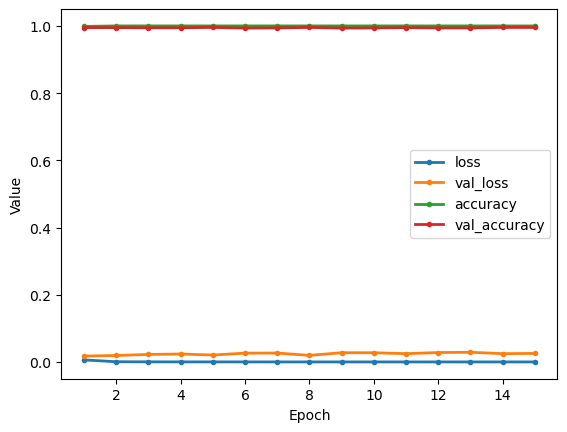

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/79 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step

 5/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step  

 9/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step

13/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

17/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

21/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

25/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

33/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

41/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

45/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

49/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

53/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

57/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

61/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

69/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


 1/79 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step

 5/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step 

 9/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

13/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

17/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

21/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

25/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

29/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

33/79 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

37/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

41/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

45/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

49/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

53/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

57/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

61/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

65/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

69/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

73/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

77/79 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [26]:
report.save()

Report saved as Output/Reports/Trihelix/report_V84X5RBC.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################